<a href="https://colab.research.google.com/github/ChocoPytoch/BISTelligence/blob/main/BISTelligence_Analytic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. **Ready**

In [2]:
!pip install pyod
!pip install plotly==5.11.0
!pip install chart-studio
!pip install IPython 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 KB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.0.7-py3-none-any.whl size=181101 sha256=4d04b5ec6d43b9fa44d1f69082f50881ef29423282434a6cdd27170d0cf78e70
  Stored in directory: /root/.cache/pip/wheels/f7/e2/c1/1c7fd8b261e72411f6509afb429c84532e40ddcd96074473f4
Successfully built pyod
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 43.1 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 KB 7.3 MB/s et

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#import문은 최상단인 이곳으로...
import numpy as np
import pandas as pd
import io
from collections import Counter
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from pyod.models.iforest import IForest
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.mcd import MCD
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler ,RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import LocalOutlierFactor
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report, accuracy_score
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
#AutoEncoder standart
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,losses,models
from tensorflow.keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
#plotly standard
import plotly.offline as pyo
from chart_studio import plotly
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from IPython.display import Image

plt.rc('font', family = 'DejaVu Sans')
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=(20,10)
pyo.init_notebook_mode()

Output hidden; open in https://colab.research.google.com to view.

> <strong>1-1. Data Read</strong>

*   data는 기존 데이터
*   pd_copy는 기존 데이터셋에서 찾은 noisy data를 발생지점 기준으로 이전 40개 인덱스, 이후 40개 인덱스에 대한 Vibration_RMS2 평균값으로 대체한 데이터


In [6]:
data = pd.read_csv('/content/drive/MyDrive/bistelligence/BIS_data/BISTelligen_Project_Data.csv')
pd_copy = data.copy()

data[data['Vibration_RMS2']<0]

,key,Pressure,Power1,Power2,Vibration_Peak1,Vibration_RMS1,Vibration_Peak2,Vibration_RMS2
982,4,1027.24236,1761.611228,2055.250646,460.673714,1.860608,1771.662869,-0.000035


In [ ]:
prev_sum=data[data['key']==4].loc[942:981]['Vibration_RMS2'].sum()
after_sum=data[data['key']==4].loc[983:1022]['Vibration_RMS2'].sum()
pd_copy.loc[data['Vibration_RMS2']<0,'Vibration_RMS2']=(prev_sum+after_sum)/80
data

,key,Pressure,Power1,Power2,Vibration_Peak1,Vibration_RMS1,Vibration_Peak2,Vibration_RMS2
0,1,1030.888889,1758.333333,1993.888889,438.298608,1.866068,1745.631110,0.890293
1,1,1019.508475,1742.881356,2095.932203,445.253134,1.870993,1615.059148,0.913187
2,1,1025.300000,1737.666667,2083.500000,452.722338,1.869140,1714.612494,0.888425
3,1,1019.383333,1751.666667,2089.833333,453.906117,1.853422,1689.548169,0.887922
4,1,1017.316667,1772.500000,2103.166667,447.134201,1.858652,1615.978827,0.881195
...,...,...,...,...,...,...,...,...
1759,6,1024.300000,1761.666667,2696.166667,471.054617,1.861856,2042.421820,1.170695
1760,6,1020.000000,1764.237288,2692.033898,465.530188,1.857697,2055.819491,1.186406
1761,6,1018.033333,1778.166667,2701.166667,450.309365,1.850355,2068.787325,1.194031
1762,6,1019.766667,1804.500000,2923.000000,470.910131,1.870685,2086.936503,1.218350


# 2. **Preprocessing & Visualization**

In [39]:
print("[key] column value count\n")
print(data['key'].value_counts(sort=False))

[key] column value count

1    330
2    300
3    308
4    326
5    250
6    250
Name: key, dtype: int64


In [67]:
def SetNormalData(data, num):
  normal_df = pd.DataFrame()
  for key in data['key'].unique():
    df = data.loc[data.key == key][:num]
    normal_df = pd.concat([normal_df, df])
  #정상치만 모은 데이터프레임
  normal_index = normal_df.index
  normal_df.reset_index(drop=True, inplace=True)

  return normal_df, normal_index

normal_df, _ = SetNormalData(data, 50)

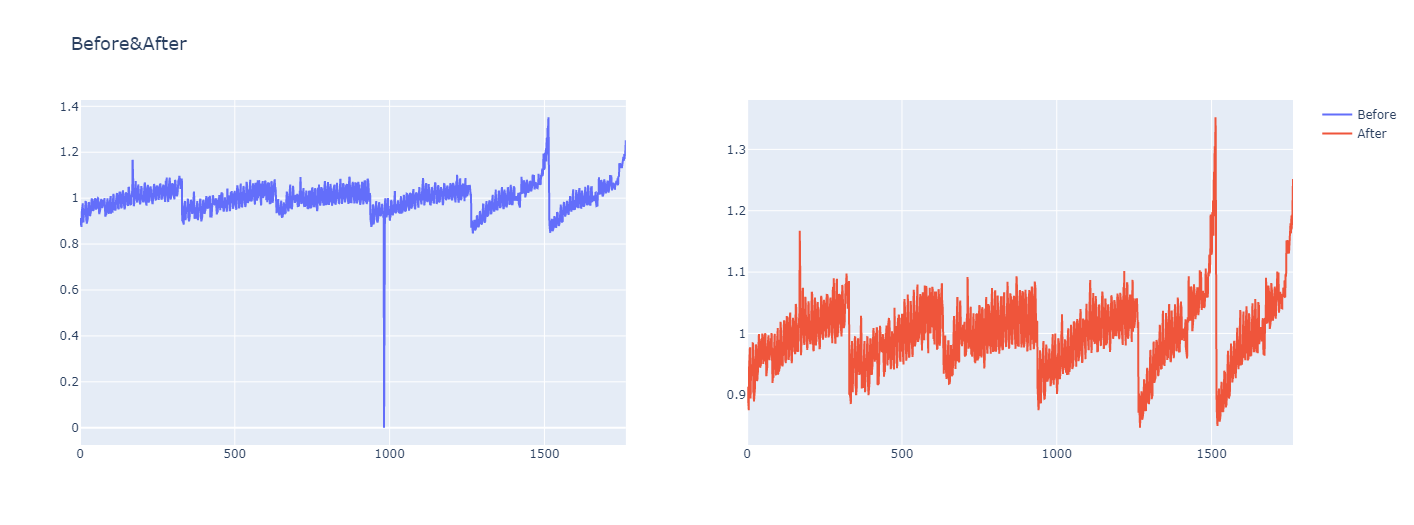

In [ ]:
'''
  이 함수는 추후 시각화할 때 사용할 목적으로 생성됨.

  기존 코드 :
  for i in range(2) :
    plt.subplot(2, 1,i+1)
    if i == 1 :
      plt.plot(pandas_copy['Vibration_RMS2'])
      title= ''.join(['Vibration_RMS2',' ChangedVer'])
    else :
      plt.plot(data['Vibration_RMS2'])
      title= ''.join(['Vibration_RMS2', ' BeforeVer'])
    plt.title(title,fontdict={'fontsize' : 18})
    plt.show()
'''
def ChangeRMS2Feature() :
  rowlist = [1, 1]
  collist = [1, 2]
  fig = make_subplots(rows=1, cols=2)
  for i in range(2) :
    if i == 0 :
      fig.add_trace(
        go.Scatter(x=data.index, y=data['Vibration_RMS2'], mode='lines', name='Before'), row=rowlist[i], col=collist[i])
    else :
      fig.add_trace(
        go.Scatter(x=data.index, y=pd_copy['Vibration_RMS2'], mode='lines', name='After'), row=rowlist[i], col=collist[i])
  fig.update_layout(title_text="Before&After",
                  title_font_size=18)
  fig.show(renderer='colab')
#ChangeRMS2Feature()
Image("drive/MyDrive/ColabNotebooks/DataBase/BeforeAfter.png")

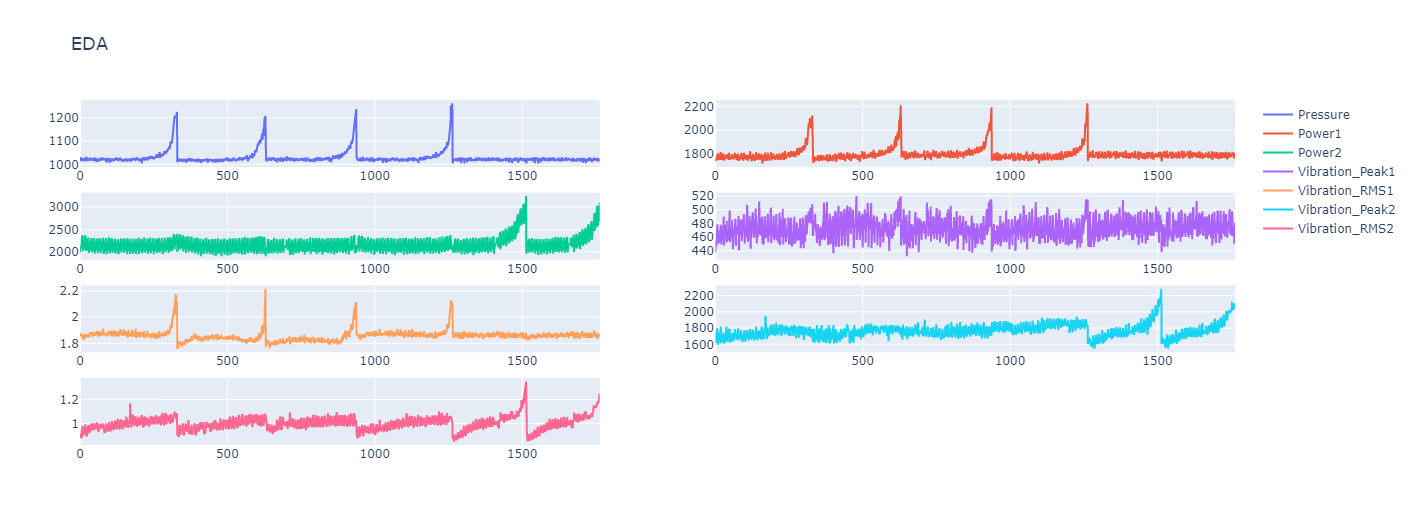

In [ ]:
'''
  이 함수는 추후 시각화할 때 사용할 목적으로 생성됨.

  기존 코드 :
  plt.subplots_adjust(hspace=0.8,wspace=0.5)
  for i,col in enumerate(data.columns[1:]):
      plt.subplot(4,2,i+1)
      plt.plot(data[col])
      plt.xticks(fontsize=15)
      plt.yticks(fontsize=15)
      plt.title(col,fontsize=18)
'''
def TotalEDA() :
  rowlist = [1, 1, 2, 2, 3, 3, 4, 4]
  collist = [1, 2, 1, 2, 1, 2, 1, 2]
  fig = make_subplots(rows=4, cols=2)
  for i,col in enumerate(data.columns[1:]):
    fig.add_trace(
      go.Scatter(x=data.index, y=data[col], mode='lines', name=col), row=rowlist[i], col=collist[i])
  fig.update_layout(title_text="EDA",
                  title_font_size=18)
  fig.show(renderer='colab')
#TotalEDA()
Image("drive/MyDrive/ColabNotebooks/DataBase/EDA.png")

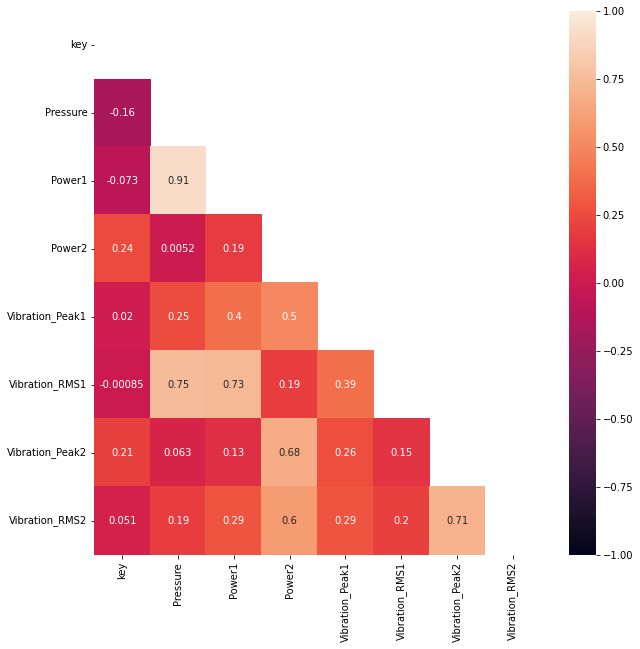

In [40]:
mask=np.zeros_like(data.corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

plt.rcParams["figure.figsize"] = (10,10)
sns.heatmap(data.corr(), vmin=-1, vmax=1,annot=True,mask=mask)

# 3. **정상/이상치 나누기**

> <strong>3-1. 함수 소개</strong>



*   splitdataset
<strong>@parameter(data, num:int, start_key:int, end_key:int)</strong>
> 이 함수는 파라미터 num을 통해 전체 데이터셋에서 해당 인덱스까지 정상치로 판단하고 정상치 데이터셋을 생성하도록 도와줍니다. 그리고 파라미터 start_key, end_key는 키별분석을 도와줍니다.
*   huepercentage
<strong>@parameter(data, num:int, percentage:int, isae:bool)</strong>
> 이 함수는 파라미터 num과 percentage를 통해 정상치 범위 및 그 내부에서 각각의 정상/이상치를 추가로 잡을 수 있도록 도와줍니다. 파라미터 isae는 추후 시각화와 최종모델링 및 Auto Encoder를 위한 hue를 분리하기 위해 설정하였습니다. 최종모델링 및 Auto Encoder를 위해 hue를 제작시 True, 이외 시각화에서는 False로 사용하면 됩니다. 함수 내부의 leftsplitlist는 정상치 파트에서 변수이며, rightsplitlist는 이상치 파트에서 변수입니다.
*   hue_count
<strong>@parameter(data)</strong>
> 이 함수는 추후 시각화에서 쓰일 이상치값의 카운트를 위 함수와 더불어 사용할 목적으로 생성되었습니다.
*   maketraintestsplit
<strong>@parameter(data, train_df)</strong>
> 이 함수는 파라미터 train_df를 통해 splitdataset 함수에서의 결과값을 Train 파트로 전체 data를 Test로 나누어 주어 분석을 용이하게 도와줍니다.

In [ ]:
def splitdataset(data, num, start_key=1, end_key=6):
    correct_dataframe = df=pd.DataFrame()
    for key in range(start_key,end_key+1):
        new_df = data[data['key']==key][:num]
        correct_dataframe = pd.concat([correct_dataframe,new_df])
    #정상치만 모은 데이터프레임
    normal_index=correct_dataframe.index
    correct_dataframe.reset_index(drop=True, inplace=True)
    correct_dataframe.head()
    return correct_dataframe,normal_index

In [ ]:
def huepercentage(data, num, percentage, isae) :
  rightsplitlist = [num, num + 330, num + 330 + 300, num + 330 + 300 + 308, num + 330 + 300 + 308 + 326, num + 330 + 300 + 308 + 326 + 250]
  leftsplitlist = [0, 330, 330 + 300, 330 + 300 + 308, 330 + 300 + 308 + 326, 330 + 300 + 308 + 326 + 250]
  pc = (100 - percentage) * 0.01
  data['hue'] = 0
  for i in range(2):
    if i == 0 :
      if isae == True :
        for j in range(6) :
          data.loc[
            leftsplitlist[j]:int((leftsplitlist[j] + num*pc))
            , :]['hue'] = 0
          data.loc[
            int((leftsplitlist[j] + num*pc)):(leftsplitlist[j] + num)
            , :]['hue'] = 1
      else :
        for j in range(6) :
          data.loc[
            leftsplitlist[j]:int((leftsplitlist[j] + num*pc*0.6))
            , :]['hue'] = 0
          data.loc[
            int((leftsplitlist[j] + num*pc*0.6)):int((leftsplitlist[j] + num*pc*0.8))
            , :]['hue'] = 1
          data.loc[
            int((leftsplitlist[j] + num*pc*0.8)):int((leftsplitlist[j] + num*pc))
            , :]['hue'] = 2
          data.loc[
            int((leftsplitlist[j] + num*pc)):(leftsplitlist[j] + num)
            , :]['hue'] = 3
    else:
      if isae == True :
        for j in range(6) :
          data.loc[
            rightsplitlist[j]:int((rightsplitlist[j] + num*pc))
            , :]['hue'] = 0
          data.loc[
            int((rightsplitlist[j] + num*pc)):(rightsplitlist[j] + num)
            , :]['hue'] = 1
      else :
        for j in range(6) :
          data.loc[
            rightsplitlist[j]:int((rightsplitlist[j] + num*pc*0.6))
            , :]['hue'] = 0
          data.loc[
            int((rightsplitlist[j] + num*pc*0.6)):int((rightsplitlist[j] + num*pc*0.8))
            , :]['hue'] = 1
          data.loc[
            int((rightsplitlist[j] + num*pc*0.8)):int((rightsplitlist[j] + num*pc))
            , :]['hue'] = 2
          data.loc[
            int((rightsplitlist[j] + num*pc)):(rightsplitlist[j] + num)
            , :]['hue'] = 3
  return data

In [ ]:
def hue_count(data) :
  summary_hue = data.hue.value_counts(ascending=True).to_frame().reset_index()
  summary_hue['percent'] = summary_hue["hue"].apply(lambda x : round(100*float(x) / len(data), 2))
  summary_hue = summary_hue.rename(columns = {"index" : "Target", "hue" : "Count"})
  return summary_hue

In [ ]:
def maketraintestsplit(data, train_df) :
  train_data=pd.DataFrame(scaler.fit_transform(train_df.drop(['key'],axis=1)),columns=train_df.columns[1:])
  test_data=data.drop(['key'],axis=1)
  test_data=pd.DataFrame(scaler.fit_transform(test_data),columns=test_data.columns)
  return train_data, test_data

In [ ]:
splitdata = data.copy()
data_01 = huepercentage(splitdata, 120, 20, True).copy()
hue_count(data_01)

,Target,Count,percent
0,1,294,16.67
1,0,1470,83.33


In [ ]:
data_0123 = huepercentage(splitdata, 120, 20, False).copy()
hue_count(data_0123)

,Target,Count,percent
0,1,228,12.93
1,2,240,13.61
2,3,294,16.67
3,0,1002,56.80


In [ ]:
scaler=RobustScaler()
#scaler=MinMaxScaler()
total_df, total_index = splitdataset(data, 120)
'''
  대부분의 분석은 train_data, test_data 사용하시면 되고,
  시각화 사용 시 아래 두개의 데이터를 사용하시면 됩니다.
'''
init_train_data, init_test_data = total_df.drop(['key'],axis=1), data.drop(['key'],axis=1)
train_data, test_data = maketraintestsplit(data, total_df)
train_data1, test_data1 = maketraintestsplit(data_01, total_df)
train_data2, test_data2 = maketraintestsplit(data_0123, total_df)

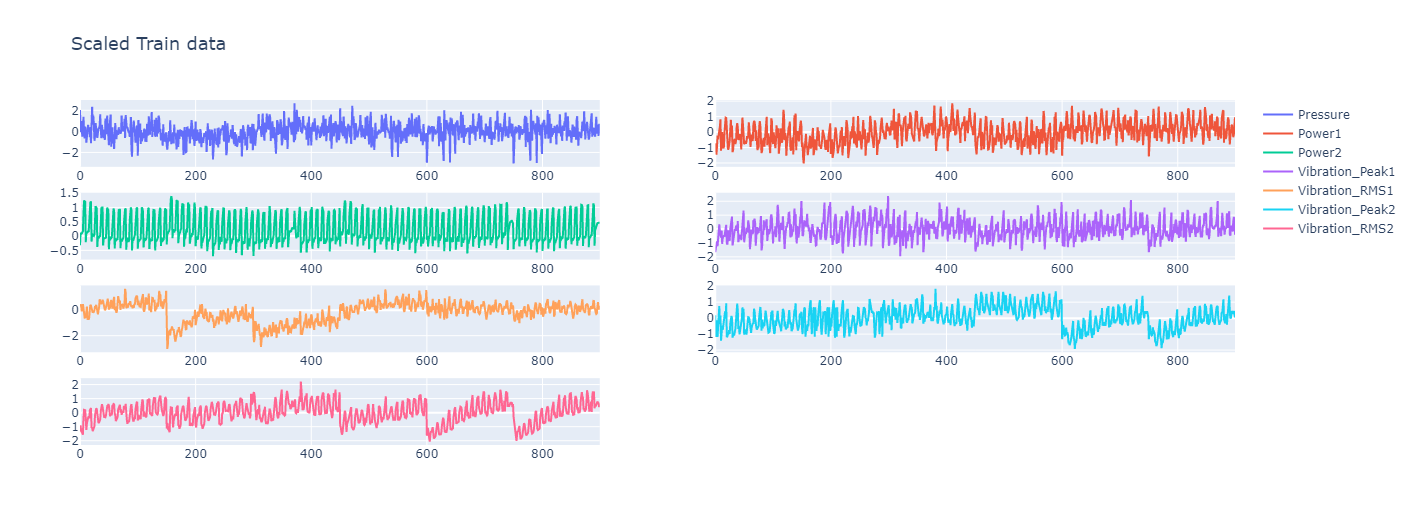

In [ ]:
'''
  이 함수는 추후 dash를 통해 heroku나 로컬로 시각화할 때 사용할 목적으로 생성됨.

  기존 코드 :
  plt.subplots_adjust(hspace=0.8,wspace=0.5)
  for i,col in enumerate(train_data.columns[:7]):
      plt.subplot(4,2,i+1)
      plt.plot(train_data[col])
      plt.xticks(fontsize=15)
      plt.yticks(fontsize=15)
      plt.title(col,fontsize=18)
'''
def ScaleTraindata() :
  rowlist = [1, 1, 2, 2, 3, 3, 4, 4]
  collist = [1, 2, 1, 2, 1, 2, 1, 2]
  fig = make_subplots(rows=4, cols=2)
  for i,col in enumerate(train_data.columns[:7]):
    fig.add_trace(
      go.Scatter(x=train_data.index, y=train_data[col], mode='lines', name=col), row=rowlist[i], col=collist[i])
  fig.update_layout(title_text="Scaled Train data",
                  title_font_size=18)
  fig.show(renderer='colab')
#ScaleTraindata()
Image("drive/MyDrive/ColabNotebooks/DataBase/Scaled Train data.png")

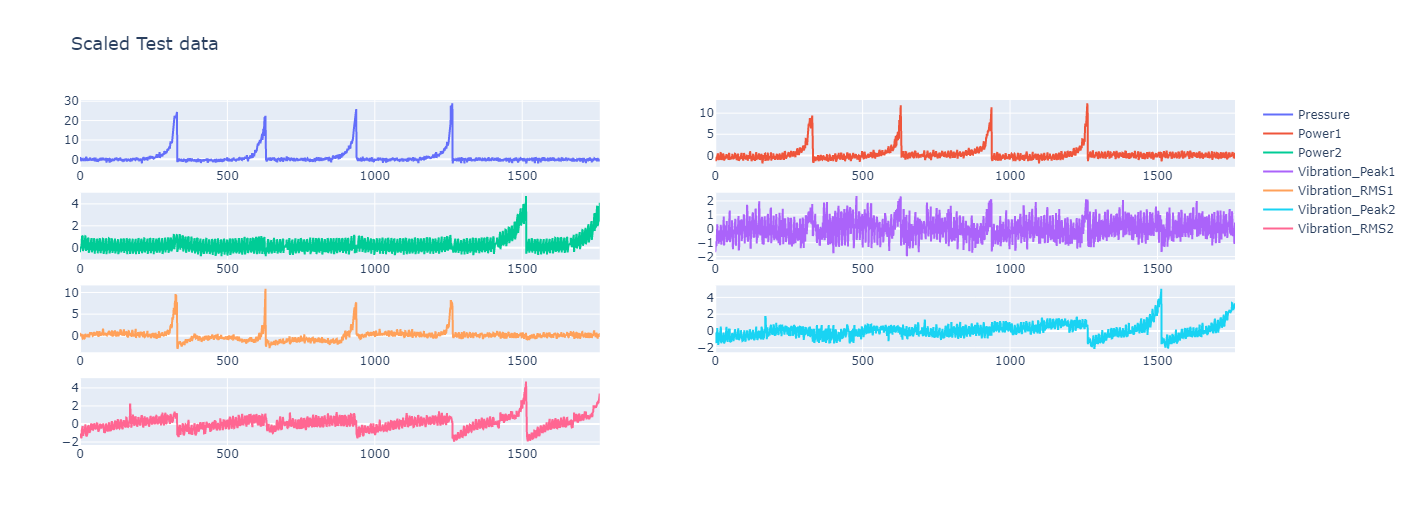

In [ ]:
'''
  이 함수는 추후 dash를 통해 heroku나 로컬로 시각화할 때 사용할 목적으로 생성됨.

  기존 코드 :
  plt.subplots_adjust(hspace=0.8,wspace=0.5)
  for i,col in enumerate(test_data.columns[:7]):
      plt.subplot(4,2,i+1)
      plt.plot(test_data[col])
      plt.xticks(fontsize=15)
      plt.yticks(fontsize=15)
      plt.title(col,fontsize=18)
'''
def ScaleTestdata() :
  rowlist = [1, 1, 2, 2, 3, 3, 4, 4]
  collist = [1, 2, 1, 2, 1, 2, 1, 2]
  fig = make_subplots(rows=4, cols=2)
  for i,col in enumerate(test_data.columns[:7]):
    fig.add_trace(
      go.Scatter(x=test_data.index, y=test_data[col], mode='lines', name=col), row=rowlist[i], col=collist[i])
  fig.update_layout(title_text="Scaled Test data",
                  title_font_size=18)
  fig.show(renderer='colab')
#ScaleTestdata()
Image("drive/MyDrive/ColabNotebooks/DataBase/Scaled Test data.png")

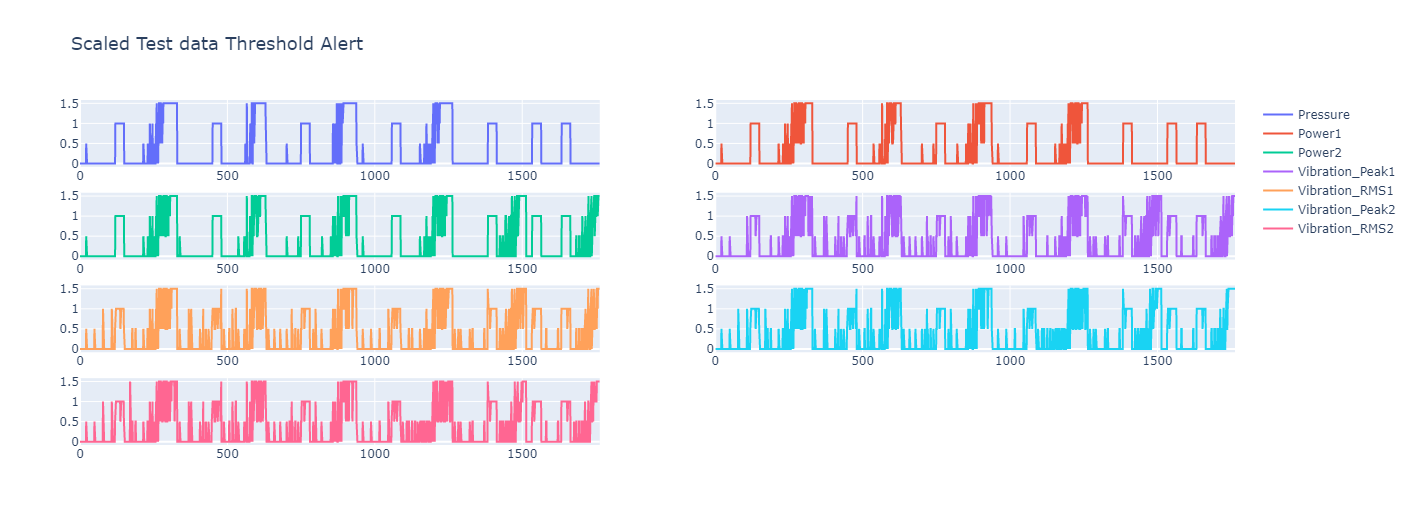

In [ ]:
'''
  이 함수는 추후 dash를 통해 heroku나 로컬로 시각화할 때 사용할 목적으로 생성됨.
'''
def UIkeythreshold(data, threshold) :
  rowlist = [1, 1, 2, 2, 3, 3, 4, 4]
  collist = [1, 2, 1, 2, 1, 2, 1, 2]
  fig = make_subplots(rows=4, cols=2)
  for i,col in enumerate(data.columns[:7]):
    for j in data[data[col] > threshold].index :
      data.iloc[j]['hue'] = 1.5
    for j in data[(threshold > data[col]) & (data[col] > threshold * 0.8)].index :
      data.iloc[j]['hue'] = 1.0
    for j in data[(threshold * 0.8 > data[col]) & (data[col] > threshold * 0.6)].index :
      data.iloc[j]['hue'] = 0.5
    fig.add_trace(
      go.Scatter(x=data.index, y=data.hue, mode='lines',name=col), row=rowlist[i], col=collist[i])
  fig.update_layout(
      title_text="Scaled Test data Threshold Alert",
      title_font_size=18,
  )
  fig.show(renderer='colab')
#UIkeythreshold(test_data1, 2)
Image("drive/MyDrive/ColabNotebooks/DataBase/Alert1.png")

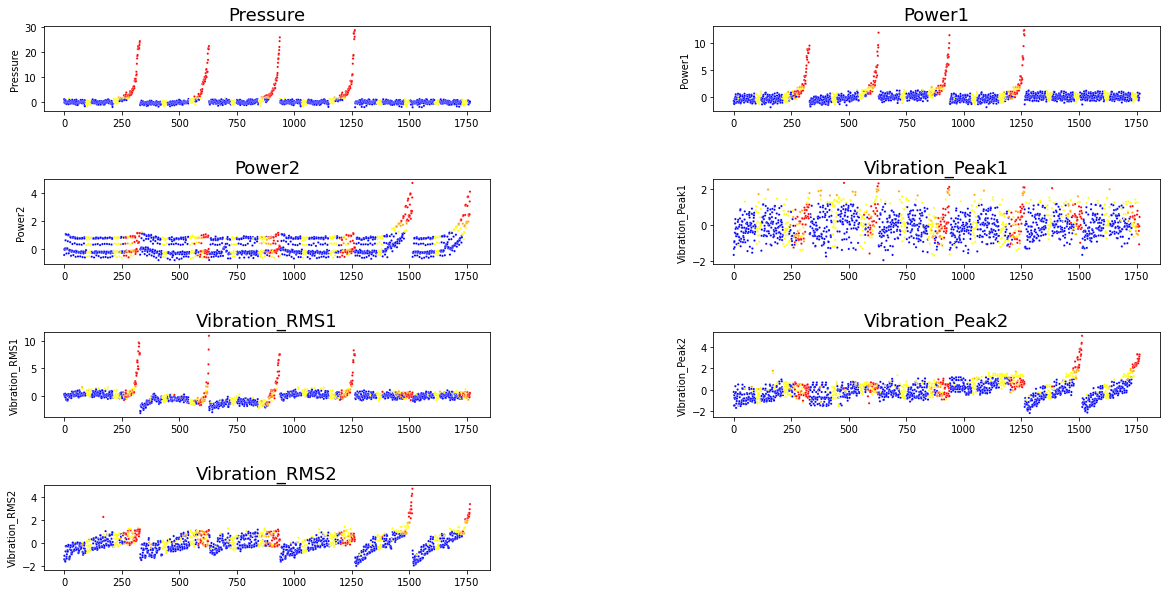

In [ ]:
'''
  이 함수는 파라미터 threshold값을 사용자를 통해 받아와 train/test dataset에 적용하여 키별로 
  해당 값을 넘으면 1차 경고(노랑), 2차 경고(주황), 3차 경고 및 작동 중지단계(빨강)으로
  시각적으로 구분을 두어 제조기계 관리를 도와줍니다.

  단, threshold값을 스케일 진행된 결과에 따라 2~5 사이값으로 제한한다.
  
  @parameter(data, threshold)
'''
def keythreshold(data, threshold) :
  plt.subplots_adjust(hspace=0.8,wspace=0.5)
  for i,col in enumerate(data.columns[:7]):
      plt.subplot(4,2,i+1)
      for j in data[data[col] > threshold].index :
        data.iloc[j]['hue'] = 3
      for j in data[(threshold > data[col]) & (data[col] > threshold * 0.8)].index :
        data.iloc[j]['hue'] = 2
      for j in data[(threshold * 0.8 > data[col]) & (data[col] > threshold * 0.6)].index :
        data.iloc[j]['hue'] = 1
      #색상 지정하기
      P_DICT = {k: 'blue' for k in data.hue.unique()}
      P_DICT[3.0]='red'
      P_DICT[2.0]='orange'
      P_DICT[1.0]='yellow'
      ax = sns.scatterplot(x = data.index, y = data[col], data = data, hue = data.hue, s = 5, legend = False, palette=P_DICT)
      plt.title(col,fontsize=18)
keythreshold(test_data1, 2)

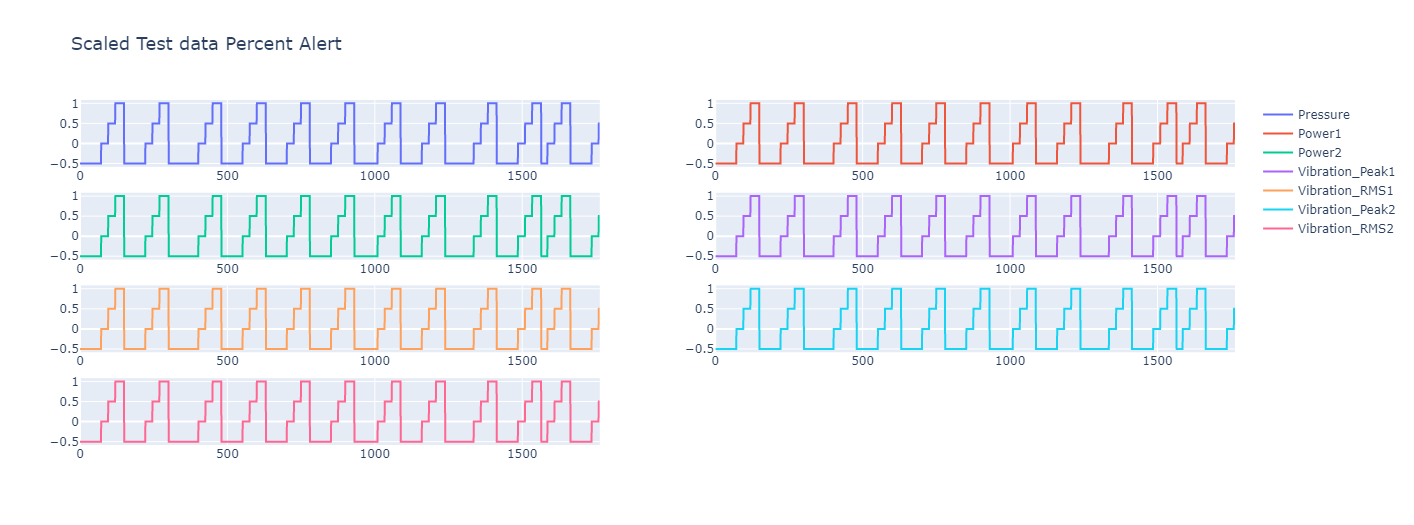

In [ ]:
'''
  이 함수는 추후 dash를 통해 heroku나 로컬로 시각화할 때 사용할 목적으로 생성됨.
'''
def UIkeywithoutthreshold(data) :
  rowlist = [1, 1, 2, 2, 3, 3, 4, 4]
  collist = [1, 2, 1, 2, 1, 2, 1, 2]
  fig = make_subplots(rows=4, cols=2)
  for i,col in enumerate(data.columns[:7]):
    fig.add_trace(
      go.Scatter(x=data.index, y=data.hue, mode='lines',name=col), row=rowlist[i], col=collist[i])
  fig.update_layout(
      title_text="Scaled Test data Percent Alert",
      title_font_size=18,
  )
  fig.show(renderer='colab')
#UIkeywithoutthreshold(test_data2)
Image("drive/MyDrive/ColabNotebooks/DataBase/Alert2.png")

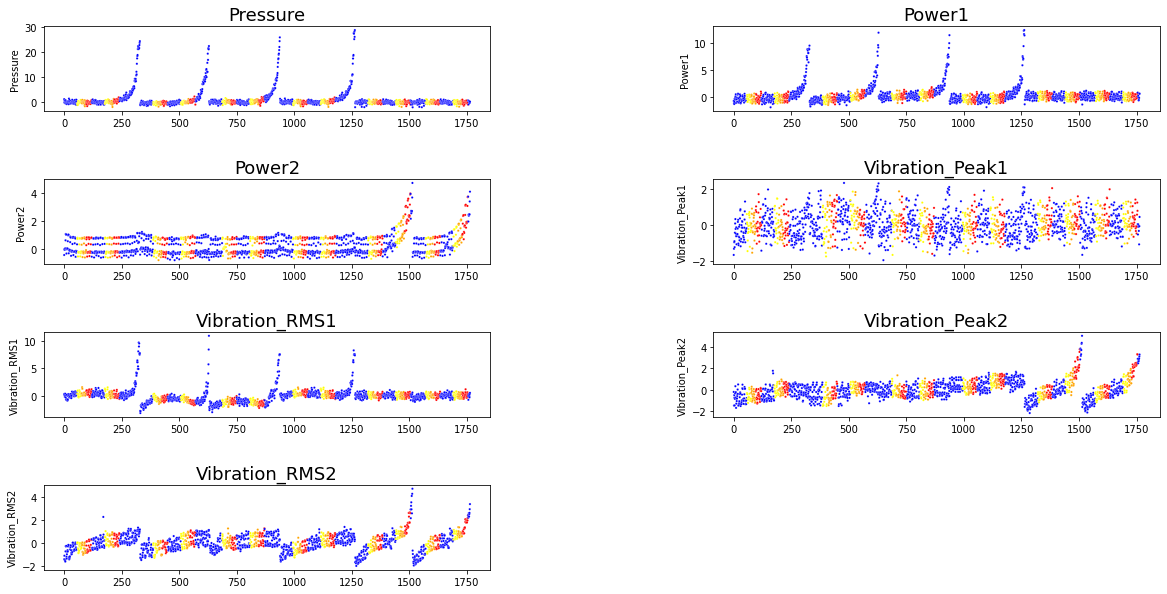

In [ ]:
'''
  이 함수는 threshold값을 입력받지 않고 위에서 진행하였듯이 
  정상치/이상치에서 일정 비율로 hue값을 생성한 데이터를
  파라미터로 받아 이를 토대로 1차 경고(노랑), 2차 경고(주황), 3차 경고 및 작동 중지단계(빨강)으로
  시각적으로 구분을 두어 제조기계 관리를 도와줍니다.

  @parameter(data)
'''
def keywithoutthreshold(data) :
  plt.subplots_adjust(hspace=0.8,wspace=0.5)
  for i,col in enumerate(data.columns[:7]):
    plt.subplot(4,2,i+1)
    #색상 지정하기
    P_DICT = {k: 'blue' for k in data.hue.unique()}
    P_DICT[1.5]='red'
    P_DICT[1.0]='orange'
    P_DICT[0.5]='yellow'
    ax = sns.scatterplot(x = data.index, y = data[col], data = data, hue = data.hue, s = 5, legend = False, palette=P_DICT)
    plt.title(col,fontsize=18)
keywithoutthreshold(test_data2)

# 4. 이상치 분석하기

><strong>4-1. LOF</strong>

In [ ]:
def LOF_Function() :
    model_lof = LocalOutlierFactor(contamination=0.01,novelty=True)
    model_lof.fit(train_data)
    lof_anomaly_score = model_lof.decision_function(test_data)
    sns.scatterplot(test_data.index,lof_anomaly_score)

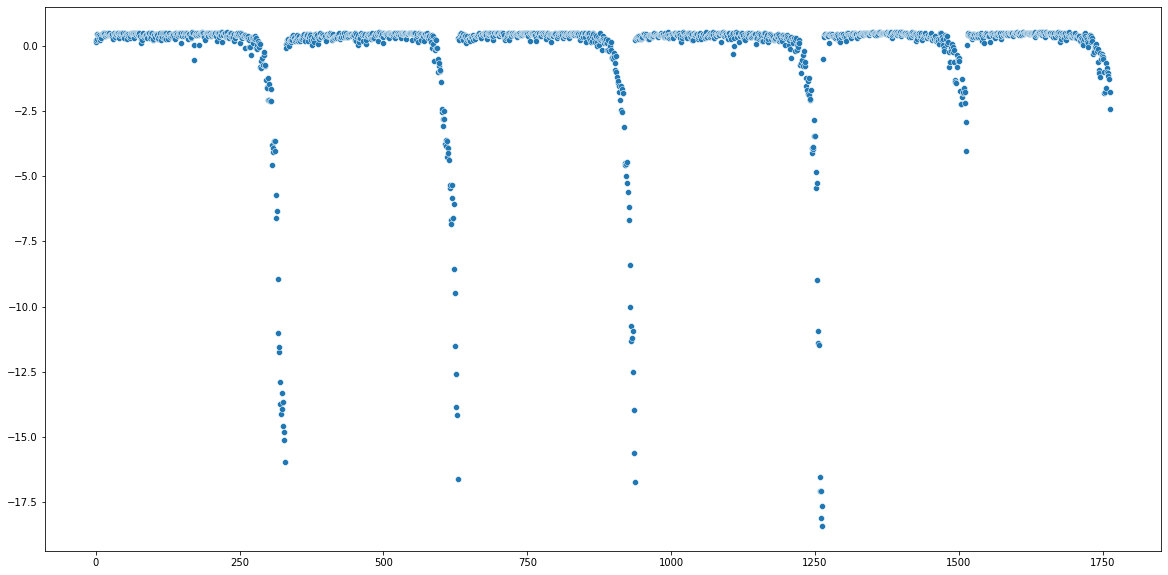

In [ ]:
LOF_Function()

><strong>4-2. MCD</strong>


In [ ]:
def MCD_Function() :
    model_mcd = MCD(support_fraction=0.8,contamination=0.01,random_state=42)
    model_mcd.fit(train_data)
    mcd_anomaly_score = model_mcd.decision_function(test_data)
    sns.scatterplot(test_data.index,mcd_anomaly_score)

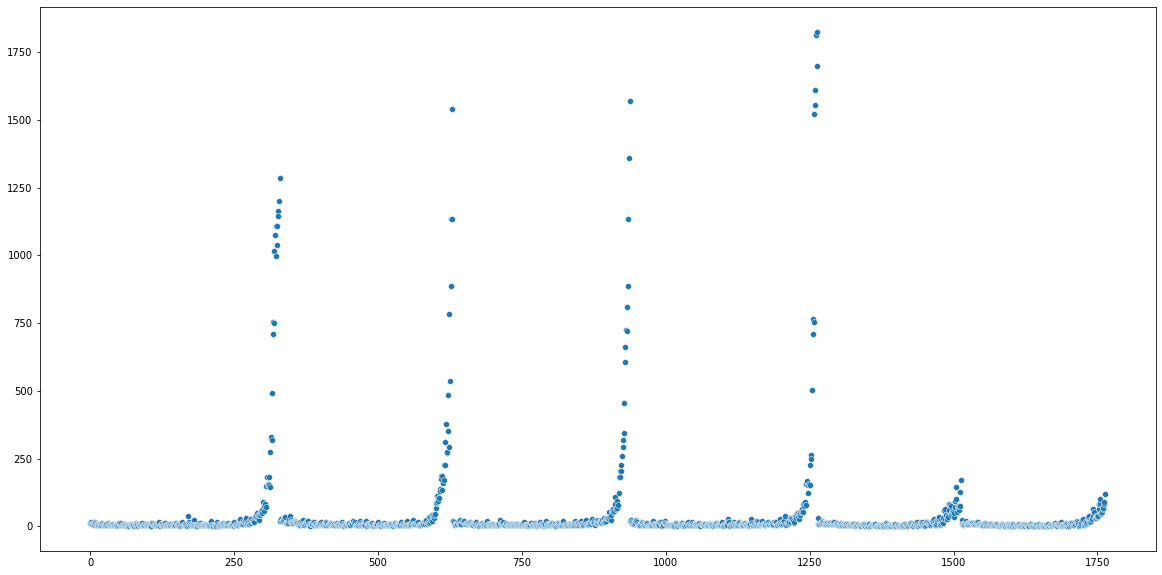

In [ ]:
MCD_Function()

><strong>4-3. Isolation Forest</strong>


In [ ]:
def ISOF_Function() :
    model_iforest = IForest(contamination=0.01,random_state=42,max_samples=300,n_estimators=200)
    model_iforest.fit(train_data)
    isof_anomaly_score = model_iforest.decision_function(test_data)
    sns.scatterplot(test_data.index,isof_anomaly_score)

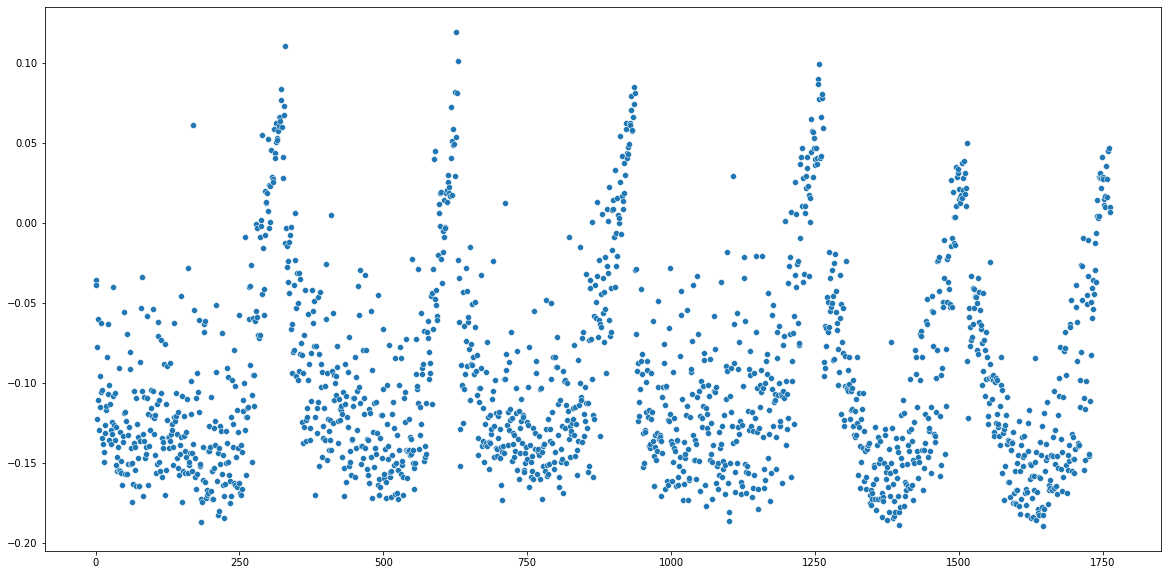

In [ ]:
ISOF_Function()

><strong>4-4. OCSVM</strong>

In [ ]:
def OCSVM_Function() :
    model_ocsvm = OneClassSVM(nu=0.01)
    model_ocsvm.fit(train_data)
    ocsvm_anomaly_score = model_ocsvm.decision_function(test_data)
    sns.scatterplot(test_data.index,ocsvm_anomaly_score)

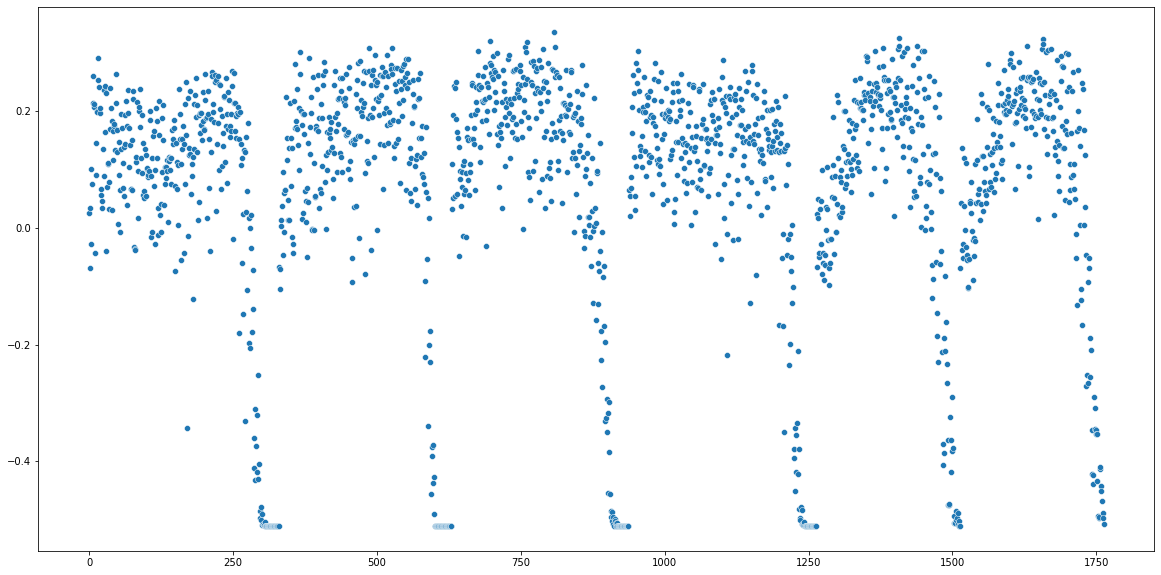

In [ ]:
OCSVM_Function()

# 5. 심화 모델링 진행

> <strong> 5-1. MinmaxScaler로 키별탐색</strong>





In [ ]:
def testdatamake(data, train_df, keytype):
  scaler=MinMaxScaler()
  test_dataframe= pd.DataFrame()
  if keytype == '1~4' :
    train_dataframe = pd.DataFrame(scaler.fit_transform(train_df.drop(['key'],axis=1)),columns=train_df.columns[1:])
    data_1to4 = data[data['key']<5]
    test_dataframe = data_1to4.drop(['key'],axis=1)
    test_dataframe = pd.DataFrame(scaler.transform(test_dataframe),columns=test_dataframe.columns)
  elif keytype == '5~6':
    train_dataframe = pd.DataFrame(scaler.fit_transform(train_df.drop(['key'],axis=1)),columns=train_df.columns[1:])
    data_5to6 = data[data['key']>=5]
    test_dataframe = data_5to6.drop(['key'],axis=1)
    test_dataframe = pd.DataFrame(scaler.transform(test_dataframe),columns=test_dataframe.columns)
  return train_dataframe, test_dataframe

> <strong> 5-2. Auto Encoder version1</strong>

In [ ]:
contamination=0.01
clf_name='AutoEncoder'

>> <strong> 5-1-(1). 전체 키 사용</strong>



In [ ]:
clf= AutoEncoder(hidden_neurons=[5,3, 2, 3, 5], epochs=100, contamination=contamination, dropout_rate=0.1, batch_size=20)
clf.fit(train_data)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 56        
                                                                 
 dropout (Dropout)           (None, 7)                 0         
                                                                 
 dense_1 (Dense)             (None, 7)                 56        
                                                                 
 dropout_1 (Dropout)         (None, 7)                 0         
                                                                 
 dense_2 (Dense)             (None, 5)                 40        
                                                                 
 dropout_2 (Dropout)         (None, 5)                 0         
                                                                 
 dense_3 (Dense)             (None, 3)                 1

AutoEncoder(batch_size=20, contamination=0.01, dropout_rate=0.1, epochs=100,
      hidden_activation='relu', hidden_neurons=[5, 3, 2, 3, 5],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7fcb0a3834c0>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

56/56 [==============================] - 0s 2ms/step


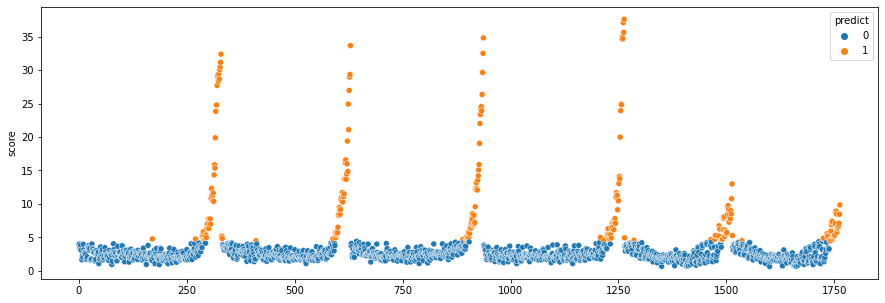

In [ ]:
predict= clf.predict(test_data)
score=clf.decision_function(test_data)
auto_test= test_data.copy()
auto_test['predict']=predict
auto_test['score']=score
sns.scatterplot(auto_test.index, auto_test['score'], hue='predict', data=auto_test)
plt.gcf().set_size_inches(15, 5)

>> <strong> 5-1-(2). 키 1~4 사용</strong>

In [ ]:
normal_df2,normal_index2 = splitdataset(data, 120, end_key=4)
train_1to4, test_1to4 = testdatamake(data, normal_df2, '1~4')

In [ ]:
clf= AutoEncoder(hidden_neurons=[5,3, 2, 3, 5], epochs=100, contamination=contamination, dropout_rate=0.1, batch_size=20)
clf.fit(train_1to4)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 7)                 56        
                                                                 
 dropout_7 (Dropout)         (None, 7)                 0         
                                                                 
 dense_9 (Dense)             (None, 7)                 56        
                                                                 
 dropout_8 (Dropout)         (None, 7)                 0         
                                                                 
 dense_10 (Dense)            (None, 5)                 40        
                                                                 
 dropout_9 (Dropout)         (None, 5)                 0         
                                                                 
 dense_11 (Dense)            (None, 3)                

AutoEncoder(batch_size=20, contamination=0.01, dropout_rate=0.1, epochs=100,
      hidden_activation='relu', hidden_neurons=[5, 3, 2, 3, 5],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7fcb0a3834c0>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

40/40 [==============================] - 0s 2ms/step


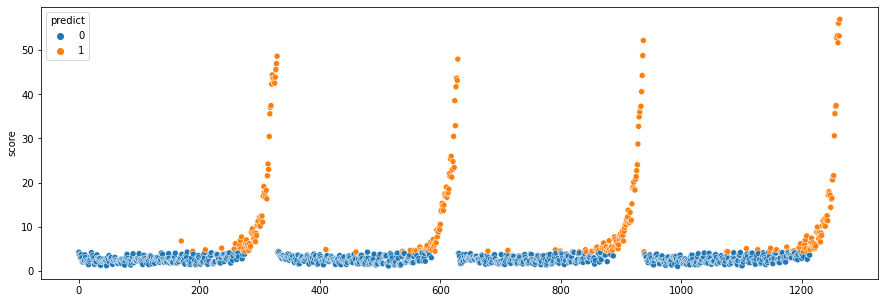

In [ ]:
predict2= clf.predict(test_1to4)
score2=clf.decision_function(test_1to4)
auto_test2= test_1to4.copy()
auto_test2['predict']=predict2
auto_test2['score']=score2
sns.scatterplot(auto_test2.index, auto_test2['score'], hue='predict', data=auto_test2)
plt.gcf().set_size_inches(15, 5)

>> <strong> 5-1-(3). 키 5~6 사용</strong>

In [ ]:
normal_df3,normal_index3 = splitdataset(data, 120, start_key=5)
train_5to6, test_5to6 = testdatamake(data, normal_df3, '5~6')

In [ ]:
clf= AutoEncoder(hidden_neurons=[5,3, 2, 3, 5], epochs=100, contamination=contamination, dropout_rate=0.1, batch_size=20)
clf.fit(train_5to6)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 7)                 56        
                                                                 
 dropout_14 (Dropout)        (None, 7)                 0         
                                                                 
 dense_17 (Dense)            (None, 7)                 56        
                                                                 
 dropout_15 (Dropout)        (None, 7)                 0         
                                                                 
 dense_18 (Dense)            (None, 5)                 40        
                                                                 
 dropout_16 (Dropout)        (None, 5)                 0         
                                                                 
 dense_19 (Dense)            (None, 3)                

AutoEncoder(batch_size=20, contamination=0.01, dropout_rate=0.1, epochs=100,
      hidden_activation='relu', hidden_neurons=[5, 3, 2, 3, 5],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7fcb0a3834c0>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

16/16 [==============================] - 0s 2ms/step


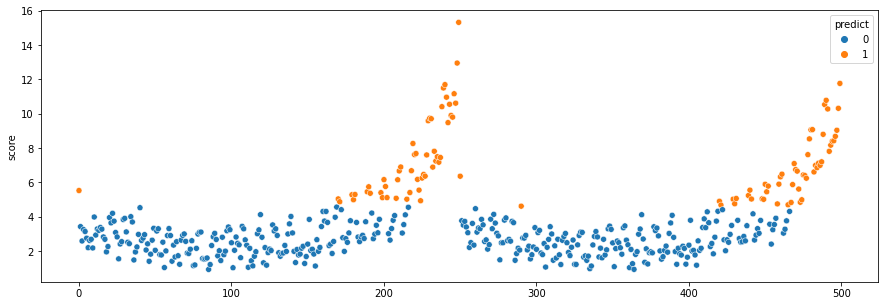

In [ ]:
predict3= clf.predict(test_5to6)
score3=clf.decision_function(test_5to6)
auto_test3= test_5to6.copy()
auto_test3['predict']=predict3
auto_test3['score']=score3
sns.scatterplot(auto_test3.index, auto_test3['score'], hue='predict', data=auto_test3)
plt.gcf().set_size_inches(15, 5)

> <strong> 5-2. Auto Encoder version2</strong>

In [ ]:
input_dim=train_data.shape[1]
tf.random.set_seed(2)
initializer = tf.keras.initializers.HeNormal(seed=2)
momentum = 0.9
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)
check_point = ModelCheckpoint('best_ae_model.h5',monitor='val_loss',mode='min',save_best_only=True)


encoder=models.Sequential([
    #input layer
    layers.InputLayer(input_shape=input_dim),

    layers.Dense(64,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(32,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(16,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(8,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(4,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
])

decoder=models.Sequential([ 
    
    layers.Dense(4,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(8,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(16,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(32,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(64,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    #output layer
    layers.Dense(input_dim,kernel_initializer=initializer),
])

model_ae=models.Sequential([
    encoder,decoder
])

model_ae.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.03), 
                    loss=keras.losses.MeanSquaredError())

history = model_ae.fit(
    train_data,train_data,
    shuffle=True,
    epochs=100,
    batch_size=128,
    validation_split = 0.3,
    callbacks = [early_stopping, check_point]
)

Epoch 1/100
4/4 [==============================] - 4s 201ms/step - loss: 1.0429 - val_loss: 0.5711
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 0.5367 - val_loss: 0.7870
Epoch 3/100
4/4 [==============================] - 0s 22ms/step - loss: 0.4677 - val_loss: 0.7397
Epoch 4/100
4/4 [==============================] - 0s 56ms/step - loss: 0.4036 - val_loss: 0.4573
Epoch 5/100
4/4 [==============================] - 0s 16ms/step - loss: 0.3617 - val_loss: 0.5651
Epoch 6/100
4/4 [==============================] - 0s 16ms/step - loss: 0.3293 - val_loss: 0.5237
Epoch 7/100
4/4 [==============================] - 0s 52ms/step - loss: 0.3125 - val_loss: 0.4047
Epoch 8/100
4/4 [==============================] - 0s 52ms/step - loss: 0.2960 - val_loss: 0.3975
Epoch 9/100
4/4 [==============================] - 0s 45ms/step - loss: 0.2823 - val_loss: 0.3897
Epoch 10/100
4/4 [==============================] - 0s 46ms/step - loss: 0.2666 - val_loss: 0.3540
Epoch 11/100
4/4 [

>> <strong> 5-2-(1). Z-Score</strong>

56/56 [==============================] - 1s 4ms/step


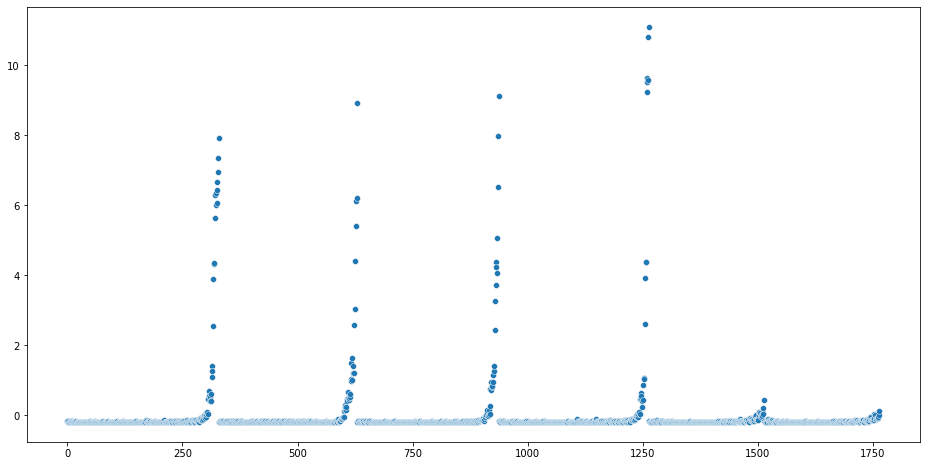

In [ ]:
model_ae = load_model('best_ae_model.h5')
reconstruction = model_ae.predict(test_data)

mse = np.mean(np.power(test_data-reconstruction,2),axis=1)

import scipy.stats as ss
z_score = ss.zscore(mse)

plt.rcParams['figure.figsize']=(16,8)
sns.scatterplot(test_data.index,z_score)

>> <strong>5-2-(2). Cosine similarity</strong>

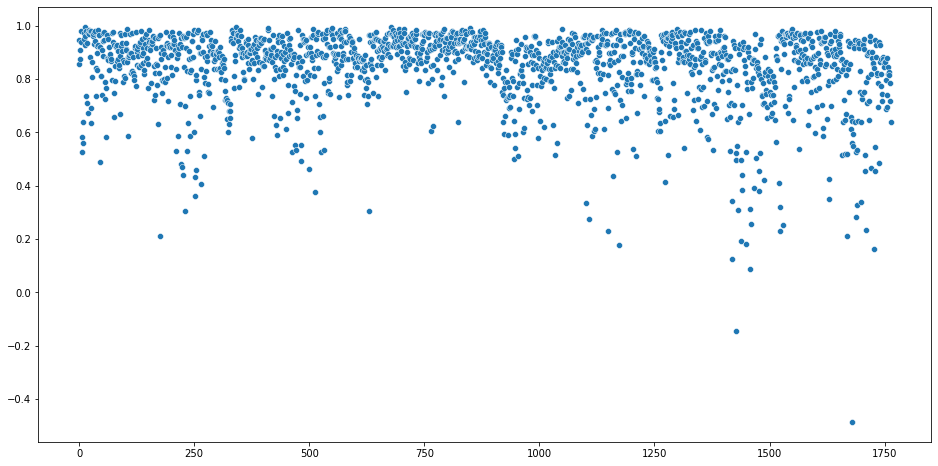

In [ ]:
# cosine similarity
import numpy as np
from numpy.linalg import norm

def cos_sim(A, B):
  return np.dot(A, B)/(norm(A)*norm(B))

reconstruction_df = pd.DataFrame(reconstruction)
cos_score=[]
for i in range(len(test_data)):
    cos=cos_sim(test_data.iloc[i,],reconstruction_df.iloc[i,])
    cos_score.append(cos)

sns.scatterplot(test_data.index,cos_score)

In [ ]:
%%shell
jupyter nbconvert --to html /content/drive/MyDrive/ColabNotebooks/BISTelligence_Analytic.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/ColabNotebooks/BISTelligence_Analytic.ipynb to html
[NbConvertApp] Writing 2393341 bytes to /content/drive/MyDrive/ColabNotebooks/BISTelligence_Analytic.html
